In [1]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

import numpy as np 
import pandas as pd 

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from konlpy.tag import Twitter
from collections import Counter 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 

font_path = 'Kakao Arena/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname = font_path, size = 10).get_name()
plt.rc('font', family = font_name,size = 12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

In [2]:
genre_gn_all = pd.read_json('Kakao Arena/genre_gn_all.json', typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [3]:
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

In [4]:
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [6]:
song_meta = pd.read_json('Kakao Arena/song_meta.json', typ = 'frame')

In [7]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [8]:
song_gnr_map = song_meta.loc[:,['id', 'song_gn_gnr_basket']]

song_gnr_map_unnest = np.dstack(( np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))),
                                                                        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)))

song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

del song_gnr_map_unnest

In [9]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [10]:
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


In [11]:
song_meta[song_meta['id'] == 456506]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
456506,"[GN0403, GN0101, GN1501, GN1504]",20060731,오버 더 레인보우 OST,321962,[1928],그리운 건 어쩔 수 없어,"[GN0400, GN1500, GN0100]",[환희],456506


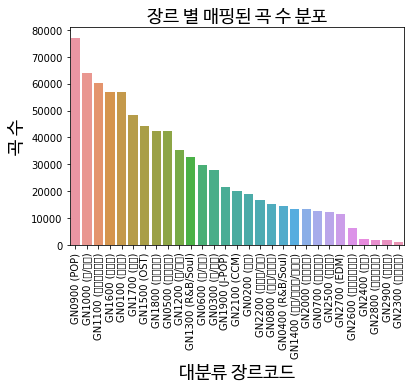

In [67]:
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포',fontproperties = fontprop)
gnr_code_name_plot.set_xlabel('대분류 장르코드',fontproperties = fontprop)
gnr_code_name_plot.set_ylabel('곡 수',fontproperties = fontprop)
plt.xticks(rotation = 90)
plt.show()

In [151]:
gnr_count.sort_values(by = 'song_cnt',ascending = False)

,gnr_code_name,song_cnt
8,GN0900 (POP),77101
9,GN1000 (록/메탈),63926
10,GN1100 (일렉트로니카),60144
15,GN1600 (클래식),57066
0,GN0100 (발라드),56820
16,GN1700 (재즈),48199
14,GN1500 (OST),44272
17,GN1800 (뉴에이지),42515
4,GN0500 (인디음악),42468
11,GN1200 (랩/힙합),35376


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

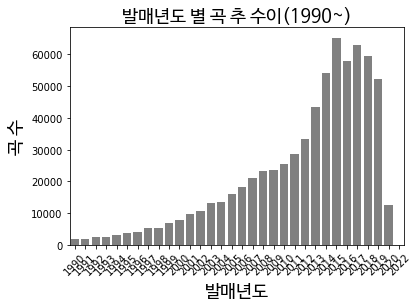

In [68]:
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

song_issue_date_filter = song_issue_date[song_issue_date.issue_year>='1990']
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title("발매년도 별 곡 추 수이(1990~)",fontproperties = fontprop)
issue_year_song_cnt_plot.set_xlabel('발매년도',fontproperties = fontprop)
issue_year_song_cnt_plot.set_ylabel('곡 수',fontproperties = fontprop)
plt.xticks(rotation = 45)
plt.show()

In [14]:
train = pd.read_json('Kakao Arena/train.json', typ = 'frame')

In [70]:
plylst_song_map = train[['id', 'songs']] 

plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))),
        np.concatenate(plylst_song_map.songs.values)
    )
)

plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

del plylst_song_map_unnest

In [74]:
plylst_tag_map = train[['id','tags']]

plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))),
        np.concatenate(plylst_tag_map.tags.values)
    )
)

plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

del plylst_tag_map_unnest

In [76]:
train_uniq_song_cnt = plylst_song_map.songs.nunique()
train_uniq_tag_cnt = plylst_tag_map.tags.nunique()

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


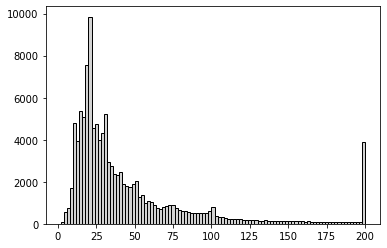

In [78]:
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

grid_list = [i*2 for i in range(1, 101)]

plt.hist(plylst_song_cnt['songs'], grid_list, color = 'lightgrey', edgecolor = 'black')
plt.show()

In [80]:
round(plylst_song_cnt.describe().loc[['min','25%','50%','mean','75%','max','std']].transpose(),2)

,min,25%,50%,mean,75%,max,std
songs,1.0,19.0,30.0,45.94,54.0,200.0,43.95


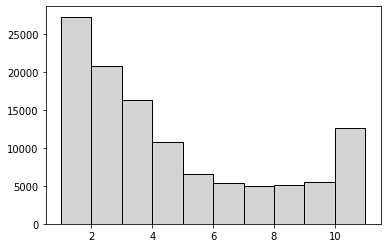

In [81]:
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = 'lightgrey', edgecolor = 'black')
plt.show()

In [85]:
round(plylst_tag_cnt.describe().loc[['min','25%','50%','mean','75%','max','std']].transpose(),2)

,min,25%,50%,mean,75%,max,std
tags,1.0,2.0,3.0,4.14,6.0,11.0,3.07


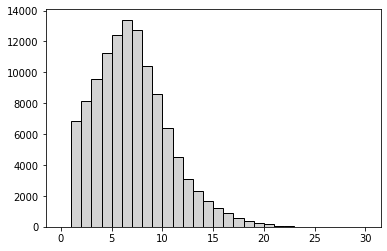

In [90]:
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0,31), color = 'lightgrey', edgecolor = 'black')
plt.show()

In [92]:
round(plylst_song_gnr_cnt.describe().loc[['min','25%','50%','mean','75%','max','std']].transpose(),2)

,min,25%,50%,mean,75%,max,std
gnr_code,0.0,4.0,6.0,6.55,9.0,26.0,3.62


In [94]:
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

song_plylst_cnt = song_plylst_cnt.assign(mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록']))

song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100,2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


In [155]:
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30000, 'mapping_plylst_cnt')
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

(pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
     [['songs','song_name','artist_name_basket','mapping_plylst_cnt']].rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명','mapping_plylst_cnt' : '수록 횟수'}))

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
...,...,...,...,...
29995,578970,울지마 사랑아,[The One (더원)],30
29996,579010,High for Me,"[Olivia Noelle, Kid Ink]",30
29997,579146,늘,[김새한길],30
29998,579325,Missing (Feat. Kimberly Anne),[Luca Schreiner],30


In [100]:
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']
single_song['songs'] = single_song['songs'].astype(str)

single_song_artist = pd.merge(single_song, song_meta[['id','song_name','artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs',right_on = 'song_id')

single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
(pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name','song_cnt']].rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'}).sort_values('수록 곡 수', ascending = False))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


In [101]:
tag_plylst_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')
tag_plylst_cnt = tag_plylst_cnt.assign(mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑']))
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100,2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수','비율(%)']]
                                       

,중복 매핑 여부,태그 수,비율(%)
0,단일 매핑,17431,59.78
1,중복 매핑,11729,40.22


In [103]:
plylst_title = train[['id', 'plylst_title']]

plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')
plylst_id_cnt = plylst_id_cnt.assign(mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음']))
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())

plylst_id_cnt_division.rename(columns = {'mapping_plylst_cnt' : '플레이리스트 아이디 수'}, inplace = True)
plylst_id_cnt_division.loc[:,'비율(%)'] = round(plylst_id_cnt_division['플레이리스트 아이디 수']/sum(plylst_id_cnt_division['플레이리스트 아이디 수'])*100,2)
plylst_id_cnt_division = plylst_id_cnt_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 이름 여부'})
plylst_id_cnt_division.loc[:, ['중복 이름 여부', '플레이리스트 아이디 수', '비율(%)']]

,중복 이름 여부,플레이리스트 아이디 수,비율(%)
0,중복 없음,108214,97.9
1,중복 있음,2317,2.1


In [156]:
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)
tag_cnt[tag_cnt['mapping_cnt']>=500].sort_values('mapping_cnt', ascending = False)

,tags,mapping_cnt
7065,기분전환,16465
5234,감성,11417
28675,휴식,11215
12894,발라드,10796
22262,잔잔한,10218
...,...,...
8583,눈물,537
26204,트로트,526
3755,electronica,524
25163,캐롤,519


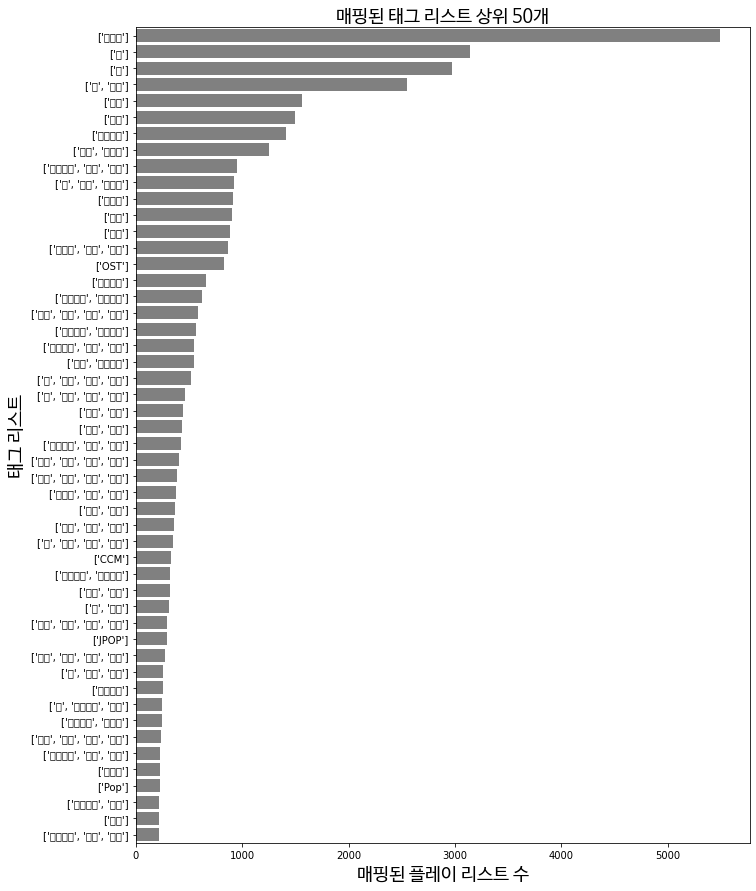

In [122]:
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(50, 'plylst_cnt')

plt.figure(figsize = (11,15))

tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list',x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title("매핑된 태그 리스트 상위 50개",fontproperties = fontprop)
tag_list_plylst_cnt_plot.set_xlabel("매핑된 플레이 리스트 수",fontproperties = fontprop)
tag_list_plylst_cnt_plot.set_ylabel("태그 리스트",fontproperties = fontprop)
plt.show()

In [125]:
tag_list_plylst_cnt

,tag_list,plylst_cnt
51670,['발라드'],5497
58918,['팝'],3147
48836,['락'],2977
48990,"['랩', '힙합']",2550
45955,['댄스'],1558
57795,['일렉'],1499
44413,['뉴에이지'],1409
54748,"['소울', '알앤비']",1250
40318,"['기분전환', '휴식', '힐링']",950
52019,"['밤', '새벽', '잔잔한']",926


In [ ]:
#연관규칙 적용, 협업 필터링

In [171]:
# !pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [175]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [188]:
test

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[],70107,,"[398985, 449403, 411543, 528044, 143048, 98020...",6,2012-09-29 01:57:26.000
1,"[나만의Best3, 인디아티스트들의추천음악]",7461,,"[196298, 269984, 267805, 175867, 529244, 63825...",0,2019-12-17 14:06:45.000
2,[드라이브],90348,,"[273433, 331003, 68432, 411659, 117793, 616860...",21,2015-05-23 10:44:48.000
3,[분위기],58617,,"[702227, 48152, 440008, 358488, 701041, 540721...",0,2019-03-14 09:47:34.000
4,[],102395,,"[630683, 481582, 528550, 285114, 506667, 17922...",38,2018-07-11 16:43:32.000
...,...,...,...,...,...,...
10735,[추억],137930,,"[323755, 397594, 445908, 570242, 221853, 20018...",16,2016-04-18 11:02:09.000
10736,"[띵곡의, 우울, 분위기, 드라이브, 산책]",936,,"[105140, 582252, 199262, 422915, 547967, 48791...",1,2020-04-08 07:15:59.000
10737,[기분전환],110589,,"[21976, 207746, 40025, 31635, 567462, 641799, ...",6,2016-06-29 00:57:21.000
10738,[여름],2605,,"[234554, 265033, 507260, 83092, 366757, 497097...",4,2015-06-06 09:52:01.000


In [193]:
tags = train['tags']

In [195]:
#태그 신뢰도 
te = TransactionEncoder()
te_ary = te.fit(tags).transform(tags)
df = pd.DataFrame(te_ary, columns = te.columns_)

In [207]:
frequent_itemsets = apriori(df, min_support = 0.01, use_colnames = True)

In [214]:
frequent_itemsets['support'].nlargest(50)

7      0.143086
4      0.099217
58     0.097462
17     0.093820
43     0.088797
11     0.087728
59     0.085017
22     0.075640
24     0.072303
18     0.066177
108    0.061058
49     0.059415
47     0.056661
54     0.055835
60     0.055731
91     0.050491
40     0.046928
25     0.042669
29     0.042243
57     0.039793
15     0.039767
73     0.039697
35     0.039619
41     0.039376
106    0.037664
93     0.037099
3      0.035126
12     0.034822
5      0.034457
27     0.034109
28     0.030651
9      0.030355
13     0.029729
19     0.029434
34     0.028652
10     0.028617
87     0.028435
81     0.028400
69     0.028243
2      0.028226
44     0.027922
32     0.027687
101    0.026662
21     0.025914
8      0.024819
104    0.024428
61     0.024333
23     0.023733
38     0.022994
20     0.021439
Name: support, dtype: float64